# MQI Feature Selection Update

In [1]:
"""Module for Feature Selection in MQI Dataset
with hand_izq removed from Data."""

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import functions_features as fn

# Cargar Datos

In [ ]:
PATH = '../data/mqi/modificados/'

# Need this to get Y and for correlation tests
mqi_datos_modificados = pd.read_csv(PATH+'mqi_datos_modificados.csv', index_col=0)

# Drop hand_izq
mqi_datos_modificados = mqi_datos_modificados.drop('hand_izq', axis=1)

# Remove features from these and save datasets
X_mqi_datos_mod = pd.read_csv(PATH+'X_mqi_datos_mod.csv', index_col=0)
X_mqi_norm_mod = pd.read_csv(PATH+'X_mqi_norm_mod.csv', index_col=0)

print(mqi_datos_modificados.shape, X_mqi_datos_mod.shape, X_mqi_norm_mod.shape)

(1253, 20) (1253, 18) (1253, 18)


In [3]:
# Variable dependiente
Y_mqi_mod = mqi_datos_modificados['cut_off_points']

# List of the true labels
labels_true = Y_mqi_mod.unique()

attributes = list(X_mqi_datos_mod.columns)
len(list(X_mqi_datos_mod.columns))

18

# Selección de Variables

## Filter method: Pearson correlation between Y (cut_off_points) and features

In [ ]:
# Get correlation between all variables
cor_mod = mqi_datos_modificados.corr(method='spearman')

### Check correlation with target variable

In [ ]:
ranked_corr_mod, correlated_features_mod = fn.get_cor_variables(cor_mod,
                                                                          'cut_off_points',
                                                                          0.3
                                                                         )

print(correlated_features_mod, "\n")
print(ranked_corr_mod)

['mean_power', 'relative_power'] 

                cut_off_points
mean_power            0.348629
relative_power        0.366466


### Check for correlation between select features

In [ ]:
# Check if the correlated features are correlated with each other
mqi_datos_modificados[correlated_features_mod].corr(method='spearman')

,mean_power,relative_power
mean_power,1.000000,0.893915
relative_power,0.893915,1.000000


Hay características correlacionadas:
- relative_power y mean_power (0.89)
- relative_power is more highly correlated with cut_off_points, so we will keep that one.
- entonces, debo quitar mean_power para eliminar las que son más correlacionadas.

In [ ]:
# remove feature that is correlated with relative_power
correlated_features_mod.remove('mean_power')

# Subconjunto de los Datos Seleccionados con Pearson Correlación
X_cor_pear_mod = mqi_datos_modificados[correlated_features_mod]

# Save to csv
X_cor_pear_mod.to_csv('../data/mqi/modificados/X_cor_pear_mod.csv')

In [8]:
def df_with_corr_feat(ranked_data):
    """Function to remove the correlated features from the ranking dataframe."""

    ranked_data = ranked_data.drop(['mean_power'], axis=0)
    ranked_data = ranked_data.reset_index()\
                    .sort_values('cut_off_points', ascending=False)\
                    .rename(columns={'index':'feat','cut_off_points':'corr'})\
                    .drop('corr', axis=1)

    return ranked_data

In [ ]:
# select feature ranking
ranked_corr_mod = df_with_corr_feat(ranked_corr_mod)

# Create feature ranking dataframe and add ranking from pearson correlation
feature_ranking_mod = fn.create_rank_df(ranked_corr_mod, attributes)

## Wrapper Method: Select Features using OLS model p-values

Feed the features to the selected Machine Learning algorithm (OLS:ordinary least squares) and based on the model performance features are added/removed.<br> 
Lowest p-value = more significant

**Remove feature with highest p-value.** Build the model again with remaining features, and run again until there are no remaining features with p-value above 0.05. A p-value of 0.05 is normal behavior. Anything less would be significant.

In [ ]:
# Get ranked features using ols
ranked_ols_mod, sel_feat_ols_mod = fn.ols_feature_selection(X_mqi_datos_mod,
                                                                      Y_mqi_mod)

# add OLS ranking data to selected features dataframe
feature_ranking_mod = fn.add_to_feat_rank_df(feature_ranking_mod,
                                                  ranked_ols_mod,
                                                  'ols')

# Create data subset of only OLS selected correlated features
X_cor_ols_mod = mqi_datos_modificados[sel_feat_ols_mod]

# Save to csv
X_cor_ols_mod.to_csv('../data/mqi/modificados/X_cor_ols_mod.csv')

## Random Forest Method
Calculate the importance of each feature in a decision tree, then average that features importance with all the other trees in the forest.

In [ ]:
# create datasets of select features using random forest and get feature ranking
X_forest_mod, ranked_for_pur = fn.random_for_feat_sel(
    X_mqi_datos_mod,
    Y_mqi_mod,
    'mqi/modificados/X_forest_mod.csv')

In [ ]:
# add Random Forest ranking data to selected features dataframe
feature_ranking_mod = fn.add_to_feat_rank_df(feature_ranking_mod,
                                                  ranked_for_pur,
                                                  'for')

# SVM Feature Selection
[Paper](http://data.conferenceworld.in/ICSTM4/P165-172.pdf) that mentions using SVM for feature extraction.
[StackOverflow](https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn) feature extraction example.

In [ ]:
# create datasets of select features using SVM and get feature ranking
X_svm_mod, ranked_svm_mod = fn.svm_feat_sel(X_mqi_norm_mod,
                                            X_mqi_datos_mod,
                                            Y_mqi_mod,
                                            'mqi/modificados/X_svm_mod.csv',
                                            .65) #.35

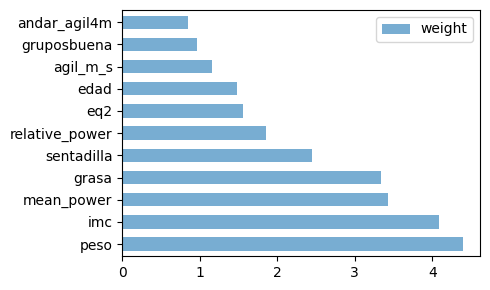

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ranked_svm_mod.plot.barh(x='feat', ax=ax, width=0.6, alpha=0.6)
ax.set_ylabel("")
plt.tight_layout()

In [ ]:
# add SVM ranking data to selected features dataframe
feature_ranking_mod = fn.add_to_feat_rank_df(
    feature_ranking_mod,
    ranked_svm_mod, 'svm')

# Final Aggregated Ranking

In [ ]:
# compute final ranking with combined feature selection methods
feature_ranking_mod = fn.compute_ranking(
    feature_ranking_mod,
    'mqi/modificados/feature_ranking_mod.csv')

In [ ]:
# Load final ranking data so ranking doesn't have to be recalculated
feature_ranking_mod = pd.read_csv('../data/mqi/modificados/feature_ranking_mod.csv',
                                       index_col=0)

In [ ]:
# Rename index names and columns
new_index = list(feature_ranking_mod.index)
new_index = [x.replace('_', ' ') for x in new_index]
new_index = [x.title() for x in new_index]

column_names = {'corr': 'Spearman', 'ols': 'Least Squares',
                'for': 'Random Forest', 'svm': 'SVM',
                'rank':'Rank', 'rank_sum':'Rank Sum'}

feature_ranking_mod['index'] = new_index
feature_ranking_mod.set_index('index', inplace=True)
feature_ranking_mod.rename(columns=column_names, inplace=True)
feature_ranking_mod

,Spearman,Least Squares,Random Forest,SVM,Rank Sum,Rank
index,,,,,,
Relative Power,1,4,2,6,13,0.076923
Peso,18,1,5,1,25,0.040000
Imc,18,2,6,2,28,0.035714
Grasa,18,5,3,4,30,0.033333
Sentadilla,18,8,4,5,35,0.028571
Mean Power,18,18,1,3,40,0.025000
Edad,18,6,9,8,41,0.024390
Agil M S,18,7,8,9,42,0.023810
Andar Agil4M,18,9,7,11,45,0.022222


In [ ]:
new_index = [
    'Relative Power', 'Weight', 'BMI', 'Fat Mass', '5STS', 'Mean Power',
    'Gait Speed (m/s)', 'Age', '4m Test', 'Balance 1', 'Balance 2', 'Groups'
            ]

feature_ranking_mod['index'] = new_index
feature_ranking_mod.set_index('index', inplace=True)

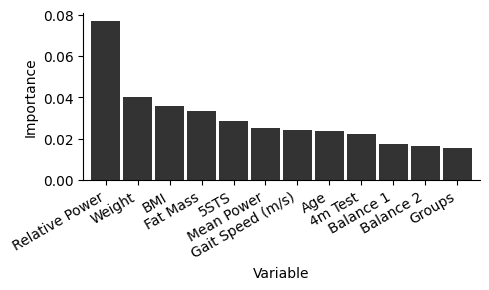

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
feature_ranking_mod[['Rank']].plot.bar(stacked=False,
                                       width=.90,
                                       rot=30,
                                       ax=ax,
                                       alpha=0.8,
                                       color=['black'])

plt.setp(ax.get_xticklabels(), ha="right")
ax.set_xlabel("Variable")
ax.set_ylabel("Importance")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_legend().remove()

fig.tight_layout()
#plt.savefig('../plots/mqi/feature_importance.png')
plt.show()

# Visualize Selected Features

In [ ]:
# Get feature counts
feature_counts_mod, feat_mod = fn.feature_counts(X_cor_pear_mod,
                                                 X_cor_ols_mod,
                                                 X_forest_mod,
                                                 X_svm_mod
                                                )

In [ ]:
# Rename index names and columns
column_names = {
    'pearson': 'Spearman', 'ols': 'OLS',
    'random_forest': 'RF',
    'svm': 'SVM', 'count':'Count'
    }

new_index = [
    'Relative Power', 'Fat Mass', 'Weight', 'Age', '4m Test',
    'Gait Speed (m/s)', 'BMI', '5STS', 'Mean Power',
    'Groups', 'Balance 1', 'Balance 2',
    ]

feat_mod['index'] = new_index
feat_mod.set_index('index', inplace=True)
feat_mod.rename(columns=column_names, inplace=True)

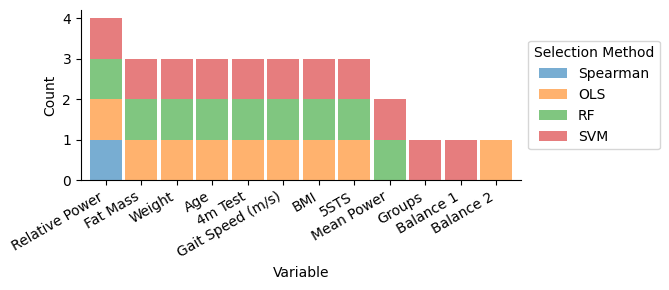

In [ ]:
fig, ax = plt.subplots(figsize=(6.75, 3))

feat_mod[['Spearman', 'OLS', 'RF', 'SVM']].plot.bar(stacked=True,
                                                    width=.90,
                                                    rot=30,
                                                    ax=ax,
                                                    alpha=0.6)

plt.setp(ax.get_xticklabels(), ha="right")
ax.set_ylabel("Count")
ax.set_xlabel("Variable")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Selection Method')

fig.tight_layout()
#plt.savefig('../plots/mqi/feature_counts.png');

# Dimensionality Reduction / PCA
Una forma de derivir un conjunto de caracterìsticas de baja dimensión de un gran congunto de variables.<br>
La primera dirección componente principal de los datos es aquella en la que las observasiones varían más.<br>

We only need to reduce down to 3 components to explain more than 95% of the data.

In [ ]:
# PCA training data
X_pca_95_mod =  fn.get_components(X_mqi_datos_mod,
                                  '../data/mqi/modificados/X_pca_95_mod.csv')

1 components explain 91.19% of the data
2 components explain 95.81% of the data



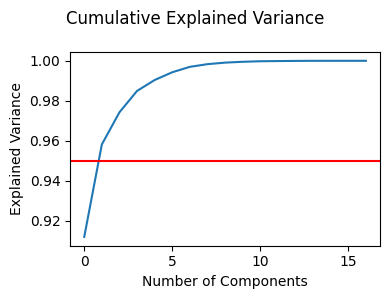

In [25]:
# 17 components to reduce to
pca = PCA(n_components=17)
pca.fit(X_mqi_datos_mod)

X_pca_17 = pd.DataFrame(pca.transform(X_mqi_datos_mod))

fig = plt.figure(figsize=(4,3))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.suptitle('Cumulative Explained Variance')

fig.tight_layout()
plt.show()